In [5]:
import os
import ast
import sys
import time
import yaml
import re
import json
from tqdm import trange

from pymongo import MongoClient
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm import trange


import pandas as pd
import numpy as np
from dotenv import load_dotenv
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Import libraries for working with language models and Google Gemini
from langchain_core.prompts import PromptTemplate
import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_core.prompts import PromptTemplate

chat_model = "llama3-8b-8192"
groq_api_key = os.environ['GROQ_API_KEY']
GEMINI_KEY   = os.environ['GEMINI_KEY']
genai.configure(api_key=GEMINI_KEY)


# Normally where to do this? (in which function?)
with open("../config.yaml", "r") as config_file:
    config = yaml.safe_load(config_file)

# Initialise mongo client.
mongo_client = MongoClient(config["database"]["uri"])

In [6]:
def load_mongodb():
    """
    Connects to the MongoDB client and fetches train and test data from specified collections.
    
    Returns:
        DataFrame: A concatenated DataFrame containing both train and test data.
        
    Raises:
        Exception: If there is an issue connecting to the MongoDB or fetching data.
    """
    # Attempt to connect to MongoDB and fetch train data
    try:
        db = mongo_client[config["database"]["name"]]
        train_documents = db[config["database"]["train_collection"]].find()
        print("Train data successfully fetched from MongoDB\n")
    except Exception as error: 
        print(f"Unable to fetch train data from MongoDB. Check your connection to the database...\nERROR: {error}\n")
        sys.exit()  # Exit the program if train data cannot be fetched

    # Attempt to fetch test data from MongoDB
    try:
        test_docs = db[config["database"]["test_collection"]].find()
        print("Test data successfully fetched from MongoDB\n")
    except Exception as error: 
        print(f"Unable to fetch test data from MongoDB. Check your connection to the database...\nERROR: {error}\n")
        sys.exit()  # Exit the program if test data cannot be fetched

    # Convert MongoDB documents to DataFrames
    df_train = pd.DataFrame.from_dict(list(train_documents))
    df_test = pd.DataFrame.from_dict(list(test_docs))
    
    # Concatenate train and test DataFrames
    df = pd.concat([df_train, df_test], axis=0)
    return df

def scale_body_embeddings(df):
    """
    Processes and scales the embedding data from a DataFrame.
    
    Args:
        df (DataFrame): A DataFrame containing the embedding data.
        
    Returns:
        np.ndarray: Scaled embedding data as a NumPy array.
    """
    print.info("Processing embedding data and scaling data...\n")
    
    # Deserialize the embeddings from strings to lists
    body_embeddings = np.array(df['embeddings'].apply(ast.literal_eval).tolist())
    return body_embeddings

def groq_header(article_titles):
    """
    Generates a common theme for a list of article titles using a language model.
    
    Args:
        article_titles (str): A string containing a list of article titles.
        
    Returns:
        str: A title that represents the common theme of the provided article titles.
    """
    # Define your desired data structure for the common theme
    class common_theme(BaseModel):
        Title: str = Field(description="Common theme of article titles")
    
    # Initialize the ChatGroq model
    chat = ChatGroq(temperature=0, model_name=chat_model)
    
    # Define the prompt template for the language model
    template = '''
    You are a news article editor. Given a list of article titles, you are to form a common theme for them in one sentence. 
    I do not require an explanation, just the title that you deem well represents the common theme.

    Series of article titles:
    {text}

    Answer format example:
    {{"Title": "Israel-Hamas Conflict and Gaza Crisis"}}
    {{"Title": "Tennis players throw rackets"}}

    Before you return the answer, ensure and double check that you have adhered the answer format instructions strictly.
    '''
    
    # Create a PromptTemplate with the defined template and input variable
    prompt = PromptTemplate(
        template=template,
        input_variables=["text"],
    )
    
    # Chain the prompt with the chat model
    chain = prompt | chat 
    
    # Invoke the chain with the article titles and get the result
    result = chain.invoke({"text": article_titles}).content
    result = json.loads(result)
    return result['Title']

def obtain_distribution_table(pre_comuted_cluster):
    """
    Computes a distribution table of cluster statistics for various distance thresholds.

    Args:
        pre_comuted_cluster (ndarray): Precomputed hierarchical clustering linkage matrix.

    Returns:
        DataFrame: A DataFrame with statistics (mean, standard deviation, and percentiles) 
                   for each distance threshold.
        dict: A dictionary with detailed statistics for each distance threshold.
    """
    dic = {}  # Dictionary to store the statistics for each distance threshold
    max_d_range = np.arange(0.4, 0.82, 0.02).tolist()  # Range of distance thresholds

    for d in max_d_range:
        d = round(d, 2)  # Round the distance threshold to two decimal places
        clusters_train = fcluster(pre_comuted_cluster, d, criterion='distance')
        
        # Get unique cluster labels and their counts
        unique_elements, counts = np.unique(clusters_train, return_counts=True)

        # Combine unique elements and counts into a dictionary for better readability
        cluster_counts = dict(zip(unique_elements, counts))  
        
        # Extract the counts (number of articles in each cluster)
        article_counts = np.array(list(cluster_counts.values()))

        # Calculate mean, median, and standard deviation
        mean_articles = np.mean(article_counts)
        stddev_articles = np.std(article_counts)

        # Specify the percentiles you want to calculate
        percentiles = sorted(list(np.arange(1, 101)))
        percentile_values = np.percentile(article_counts, percentiles)

        # Initialize the dictionary for the current distance threshold
        dic[d] = {}
        dic[d]['num_clusters'] = len(article_counts)

        # Add mean, median, and standard deviation to the dictionary
        dic[d]['mean'] = round(mean_articles, 2)
        dic[d]['std'] = round(stddev_articles, 2)

        # Add the percentiles to the dictionary
        for i, percentile in enumerate(percentiles):
            dic[d][f'{percentile}'] = round(percentile_values[i], 2)

    # Convert the dictionary to a DataFrame
    data = []
    for d, stats in dic.items():
        for key, value in stats.items():
            if key in ['mean', 'std']:
                data.append({'max_d': d, 'statistic': key, 'value': value})
            elif key not in ['num_clusters']:
                percentile = key
                data.append({'max_d': d, 'statistic': f'{percentile}', 'value': value})

    # Create DataFrame with all values
    distribution_df = pd.DataFrame(data)

    # Pivot the DataFrame to have percentiles and other statistics as columns
    pivot_df = distribution_df.pivot(index='max_d', columns='statistic', values='value')
    pivot_df.reset_index(inplace=True)

    # Rename the columns for better readability (optional)
    pivot_df.columns.name = None
    pivot_df.rename(columns={col: f'{col}' if isinstance(col, int) else col for col in pivot_df.columns}, inplace=True)
    return pivot_df, dic

def plot_distribution(dic, max_d):
    """
    Plots the distribution of article counts for a specified distance threshold.

    Args:
        dic (dict): Dictionary containing cluster statistics for various distance thresholds.
        max_d (float): The specific distance threshold to plot.
    """
    data = dic[max_d]
    
    # Extract percentile values (excluding 'num_clusters', 'mean', 'std')
    percentiles = {int(k): v for k, v in data.items() if k not in ['num_clusters', 'mean', 'std']}

    # Create lists for x (percentiles) and y (article counts)
    x = list(percentiles.keys())
    y = list(percentiles.values())

    # Plotting
    plt.figure(figsize=(20, 12))
    plt.bar(x, y, color='skyblue', edgecolor='black')
    plt.xlabel('Percentiles')
    plt.ylabel('Number of Articles')
    plt.title('Distribution of Articles at Each Percentile')
    plt.xticks(ticks=range(0, 101, 10))
    plt.grid(axis='y')

    # Show the plot
    plt.show()
    
def plot_stats(dic):
    """
    Plots the mean and standard deviation of article counts across different distance thresholds.

    Args:
        dic (dict): Dictionary containing cluster statistics for various distance thresholds.
    """
    # Prepare data for plotting
    datasets = [{'max_d': max_d, 'num_clusters': props['num_clusters'], 'mean': props['mean'], 'std': props['std']} for max_d, props in dic.items()]

    # Extract max_d, mean, and std values
    max_ds = [data['max_d'] for data in datasets]
    means = [data['mean'] for data in datasets]
    stds = [data['std'] for data in datasets]

    # Plotting
    plt.figure(figsize=(20, 12))

    # Plot mean values with error bars for standard deviation
    plt.errorbar(max_ds, means, yerr=stds, fmt='-o', capsize=5, capthick=2, ecolor='red', color='blue', label='Mean with Std Dev')

    # Labeling the plot
    plt.xlabel('max_d')
    plt.ylabel('Mean Number of Articles')
    plt.title('Mean and Standard Deviation of Articles Across Datasets')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

def find_clusters_in_percentile(df, cluster_counts, pivot_df, max_d, percentile):
    """
    Identifies and labels clusters in the specified percentile based on article count.

    Args:
        df (DataFrame): DataFrame containing article data with cluster labels.
        cluster_counts (dict): Dictionary containing cluster labels and their counts.
        pivot_df (DataFrame): DataFrame containing percentile statistics for various distance thresholds.
        max_d (float): The distance threshold to consider.
        percentile (int): The percentile to find clusters for (e.g., 99 for the 99th percentile).

    Returns:
        list: A list of dictionaries containing details of clusters in the specified percentile.
    """
    # Filter the DataFrame for the specified distance threshold
    distri_df = pivot_df[round(pivot_df["max_d"], 2) == max_d].reset_index()

    # Determine the article count threshold for the specified percentile
    percentile_article_num = distri_df[str(percentile)][0]
    next_percentile = percentile + 1 if percentile < 99 else percentile

    # Identify clusters that meet the article count criteria for the specified percentile
    clusters_at_percentile = [
        cluster for cluster, cluster_count in cluster_counts.items()
        if (percentile == 99 and cluster_count >= percentile_article_num) or
        (cluster_count >= percentile_article_num and cluster_count < distri_df[str(next_percentile)][0])
    ]

    # Limit the number of clusters to process if there are more than 30
    if len(clusters_at_percentile) > 30:
        clusters_at_percentile = clusters_at_percentile[:25]
        print("More than 30 articles in this percentile, shortening it to 25 to account for Groq limits...\n")

    percentile_articles = []

    # Generate AI labels and details for each identified cluster
    for i in trange(len(clusters_at_percentile)):
        label = list(cluster_counts.keys())[clusters_at_percentile[i] - 1]
        s = ""
        count = 0

        # Accumulate article titles for the current cluster
        for t in df[df['Cluster_labels'] == label]['Title'].values.tolist():
            s += f"- {t}\n"
            count += 1

        # Generate an AI label for the cluster
        generated_label = groq_header(s)

        # Create a dictionary with cluster details
        cluster_details = {
            'Cluster number': clusters_at_percentile[i],
            'Cluster label': generated_label,
            'Number of articles': count
        }
        percentile_articles.append(cluster_details)

    # Convert numeric types in the cluster details to standard Python types
    for d in percentile_articles:
        for key, value in d.items():
            if isinstance(value, (np.int32, np.int64)):
                d[key] = int(value)
            elif isinstance(value, (np.float32, np.float64)):
                d[key] = float(value)

    # Convert the list of dictionaries to a JSON string for display
    json_string = json.dumps(percentile_articles, indent=4)

    # Print the generated labels and details of the clusters
    print(f"Generated Labels of clusters in the {percentile} percentile:\n")
    for d in percentile_articles:
        print(f"- {d['Cluster label']}\n")
    print(f"Details of clusters in the {percentile} percentile:\n")
    print(json_string)
    
    return percentile_articles

def view_cluster(df, cluster_counts, cluster_num):
    """
    Displays the titles and AI-generated label of a specified cluster.

    Args:
        df (DataFrame): DataFrame containing article data with cluster labels.
        cluster_counts (dict): Dictionary containing cluster labels and their counts.
        cluster_num (int): The cluster number to view (1-based index).

    Returns:
        None
    """
    # Get the actual label of the cluster from the dictionary using the 1-based index
    label = list(cluster_counts.keys())[cluster_num - 1]
    
    # Initialize a string to accumulate article titles
    s = ""
    count = 0  # Counter for the number of articles in the cluster

    # Retrieve article titles for the specified cluster label and concatenate them into the string
    for t in df[df['Cluster_labels'] == label]['Title'].values.tolist():
        s += f"- {t}\n"
        count += 1  # Increment the article count

    # Generate an AI label for the cluster using the concatenated titles
    generated_label = groq_header(s)
    
    # Print the cluster number and AI-generated label
    print(f"Cluster No: {label}\n")
    print(f"AI generated label of cluster: \n{generated_label}")
    print("-" * 80)
    
    # Print each article title in the cluster
    for t in df[df['Cluster_labels'] == label]['Title'].values.tolist():
        print(f"- {t}\n")
    
    # Print the total number of articles in the cluster
    print(f"Number of articles in cluster: {count}")


Train data successfully fetched from MongoDB

Test data successfully fetched from MongoDB



## Exploration to see the clusters that are in the different percentiles

In [49]:
# Load database
df= load_mongodb()

# Change type of embeddings accordingly
train_embeddings = scale_body_embeddings(df)

# Pre computed hierarchical clustering
Z = linkage(train_embeddings, method='average', metric='cosine')

# Obtain distribution table
pivot_df, dic = obtain_distribution_table(Z)

# Pretty Print distribution table
print("Distribution for Body embeddings:")
print(tabulate(pivot_df, headers='keys', tablefmt='psql'))

Distribution for Body embeddings:
+----+---------+-----+------+-------+------+------+------+------+------+------+------+------+------+-----+------+------+------+------+------+------+------+------+------+------+-----+------+------+------+------+------+------+------+------+------+------+-----+------+------+------+------+------+------+------+------+------+------+-----+------+------+------+------+------+------+------+------+------+------+-----+------+------+------+------+-------+------+-------+------+------+-------+------+------+-------+------+-------+-------+-------+-------+-------+------+-------+-----+------+-------+-------+-------+-------+------+-------+-------+-------+-------+-----+------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+-------+
|    |   max_d |   1 |   10 |   100 |   11 |   12 |   13 |   14 |   15 |   16 |   17 |   18 |   19 |   2 |   20 |   21 |   22 |   23 |   24 |   25 |   26 |   27 |   28 |   29 |   3 |   30 |   31 |   32 |   33 |

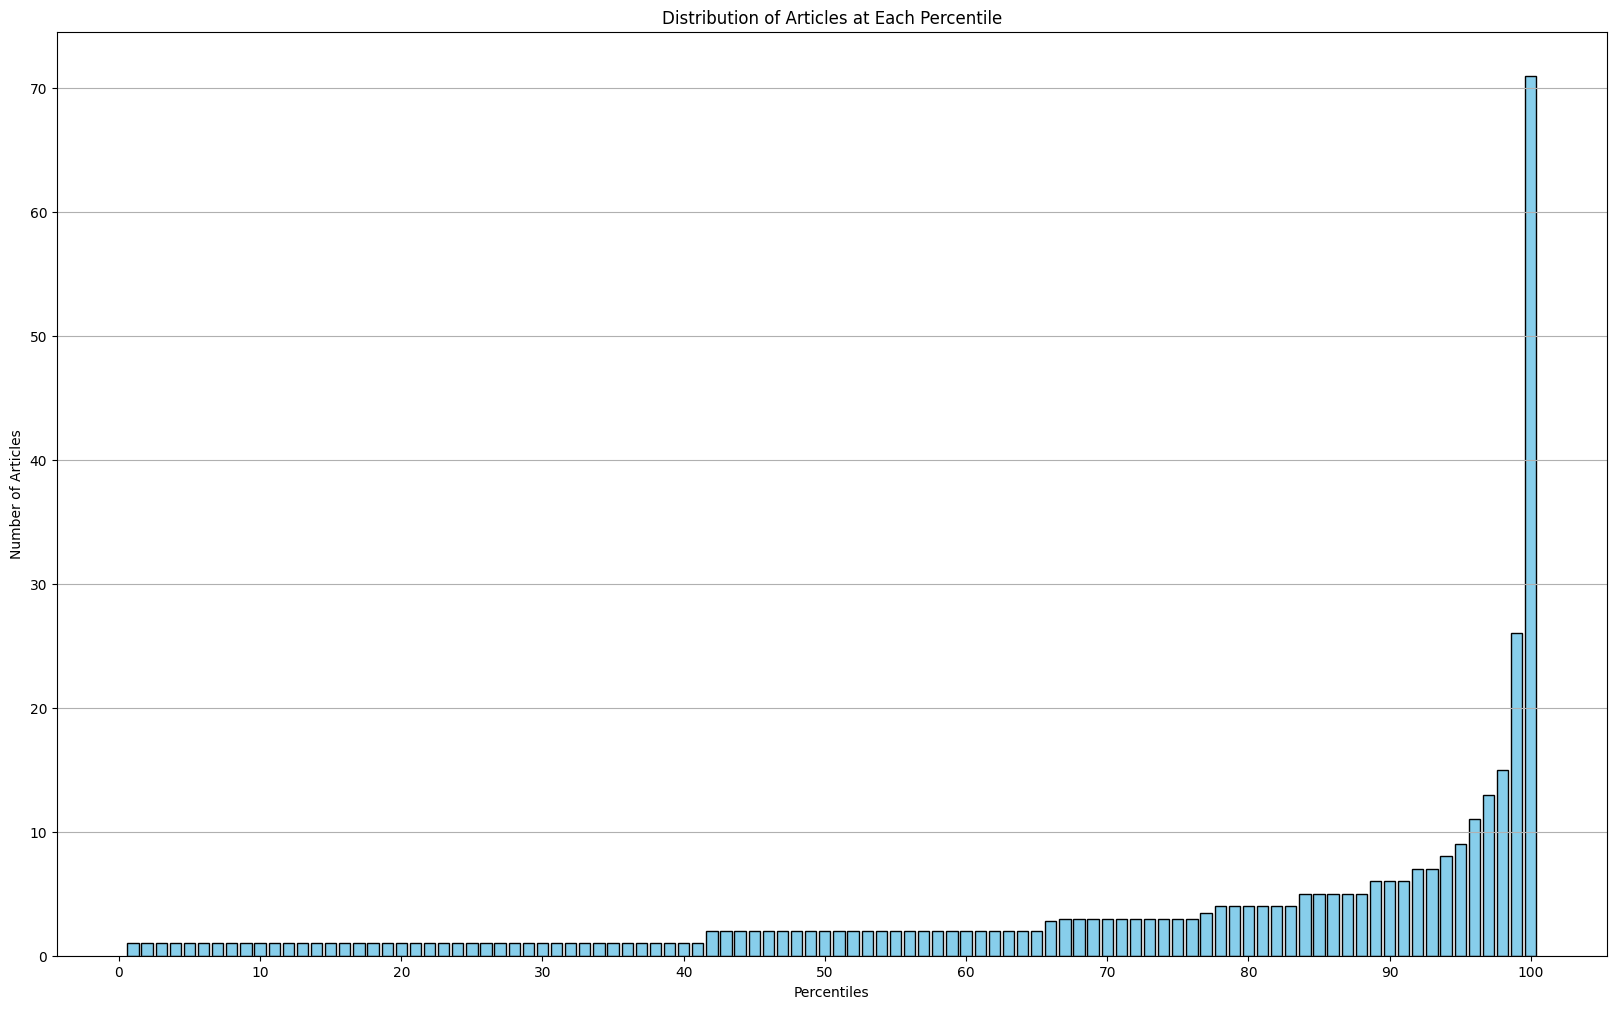

In [44]:
plot_distribution(dic, 0.58)

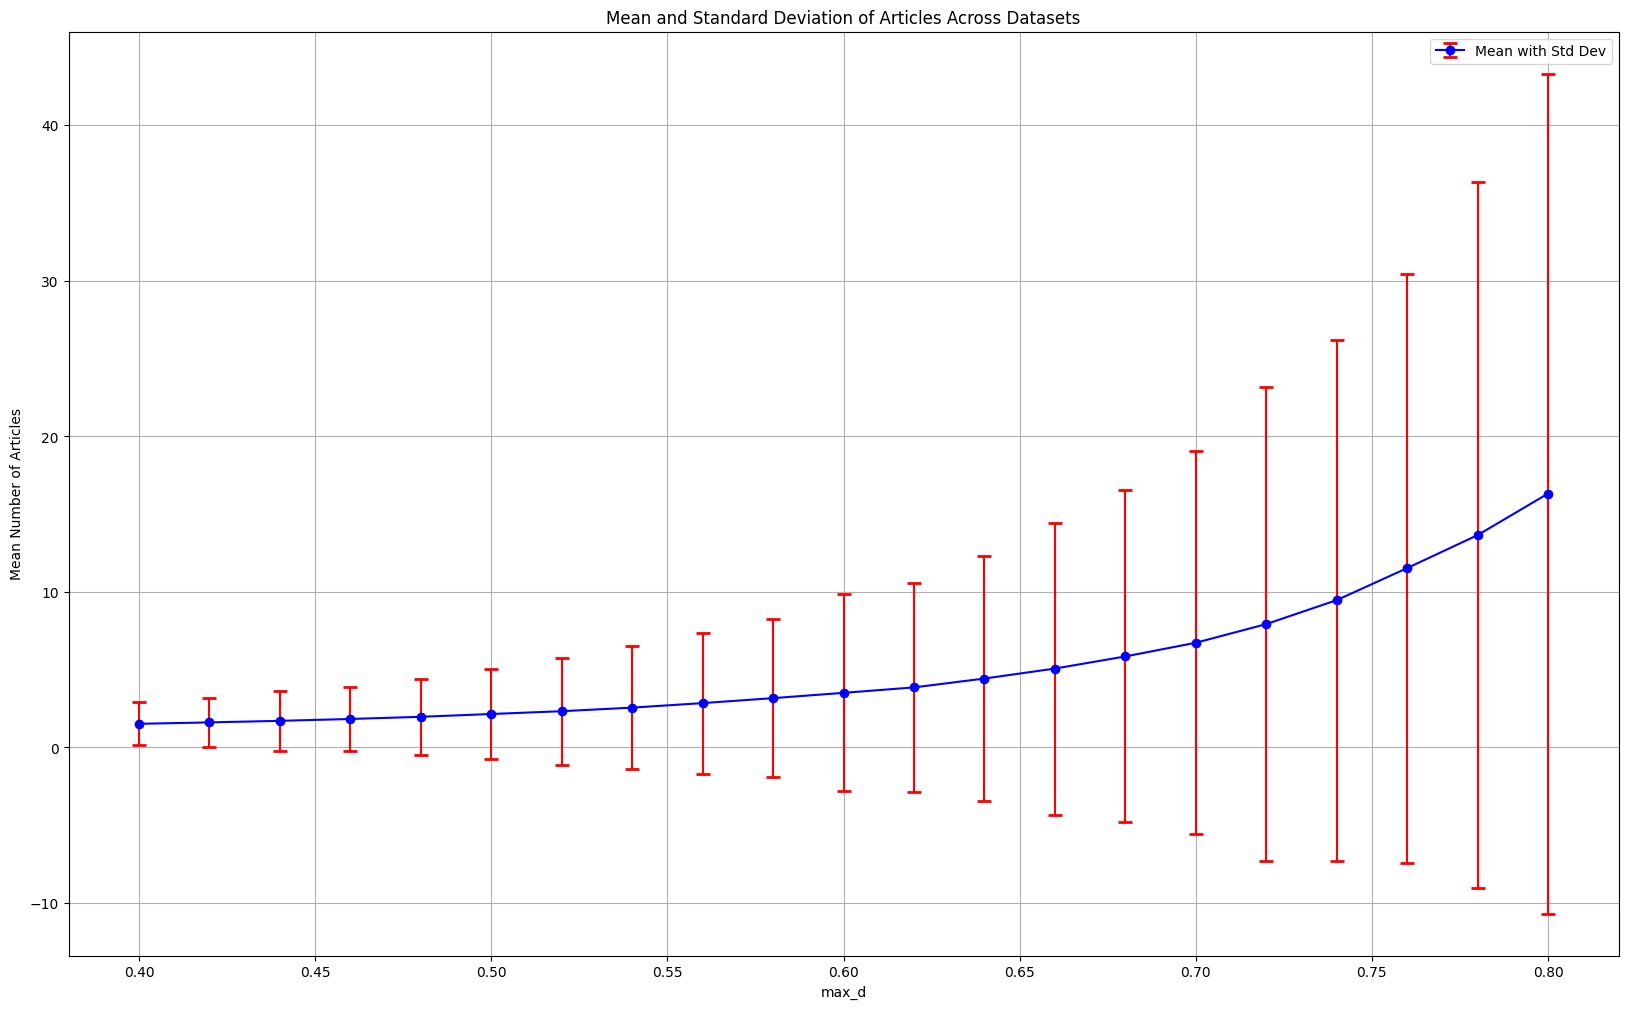

In [52]:
plot_stats(dic)

In [57]:
# Use pre computed cluster to predict at particular max_d
# max_d of 0.56 to 0.6 seem to be the optimal 
max_d = 0.58
clusters_train = fcluster(Z, max_d, criterion='distance')
    
# Get unique elements and their counts
unique_elements, counts = np.unique(clusters_train, return_counts=True)

# Combine unique elements and counts into a dictionary for better readability
cluster_counts = dict(zip(unique_elements, counts))  
    
# Extract the counts (number of articles in each cluster)
article_counts = np.array(list(cluster_counts.values()))

labels = clusters_train.tolist()
df['Cluster_labels'] = labels

In [58]:
details = find_clusters_in_percentile(df, pivot_df, 0.58, 99)

100%|██████████| 7/7 [00:06<00:00,  1.11it/s]

Generated Labels of clusters in the 99 percentile:

- Tennis players and tournaments

- Rugby World Cup

- Cricket World Cup and International Matches

- English Premier League and Football Match Updates

- Russia-Ukraine Conflict and War Efforts

- Israel-Hamas Conflict and Gaza Crisis

- Israel-Hamas Conflict and Gaza Crisis

Details of clusters in the 99 percentile:

[
    {
        "Cluster number": 13,
        "Cluster label": "Tennis players and tournaments",
        "Number of articles": 28
    },
    {
        "Cluster number": 46,
        "Cluster label": "Rugby World Cup",
        "Number of articles": 50
    },
    {
        "Cluster number": 48,
        "Cluster label": "Cricket World Cup and International Matches",
        "Number of articles": 44
    },
    {
        "Cluster number": 70,
        "Cluster label": "English Premier League and Football Match Updates",
        "Number of articles": 34
    },
    {
        "Cluster number": 472,
        "Cluster label": "Russi

In [ ]:
view_cluster(df, cluster_counts, 3)

## Exporting these details into CSV

In [ ]:
num_clusters = len(set(labels))
cluster = df[df["Cluster_labels"] == 1].reset_index()
cluster_title_ls = cluster['Title'].values.tolist()

def get_cluster_details(df, test_cluster):
    cluster = df[df["Cluster_labels"] == test_cluster].reset_index()
    cluster_title_ls = cluster['Title'].values.tolist()
    cluster_size = len(cluster_title_ls)
    if cluster_size > 1:
        titles = ""
        # Generate the list
        for i in range(len(cluster_title_ls)):
            titles += f"- {cluster_title_ls[i]}\n"
        # generate label for this cluster
        cluster_label = groq_header(titles)
    else:
        cluster_label = "SAME AS TITLE: " + cluster_title_ls[0]
    return cluster_size, cluster_label

details = {}
batch_size = 30
total = num_clusters + 1  # Update this to the total number of iterations you need

# Calculate the number of full batches
num_batches = (total + batch_size - 1) // batch_size

# Process each full batch
k = 0
for batch in range(num_batches):
    start = batch * batch_size + 1
    end = min(start + batch_size, total + 1)
    for i in trange(start, end):
        details[i] = {}
        size, label = get_cluster_details(df, i)
        details[i]['Cluster_size'] = size
        details[i]['Cluster_label'] = label
    if batch < num_batches - 1:
        print(f"Batch {k+1}/{num_batches} completed, cooling down for 60 seconds...\n")
        time.sleep(60)  # Pause for 40 seconds after each batch
    k += 1

# Process any remaining items that don't form a full batch
remainder = total % batch_size
if remainder > 0 and num_batches * batch_size + 1 <= total:
    start = num_batches * batch_size + 1
    end = total + 1
    for i in trange(start, end):
        details[i] = {}
        size, label = get_cluster_details(df, i)
        details[i]['Cluster_size'] = size
        details[i]['Cluster_label'] = label

details.popitem()
new_df = df.drop(['_id', 'embeddings', 'combined', 'tags_embeddings', 'Title_embeddings', 'phrase_Bert_tags_embeddings'], axis=1)
details_df = pd.DataFrame.from_dict(details, orient='index').reset_index()
details_df.rename(columns={'index': 'Cluster_id', 'Cluster_label': 'Generated_labels'}, inplace=True)
merged_df = pd.merge(new_df, details_df, left_on='Cluster_labels', right_on='Cluster_id', how='left')
merged_df.drop(columns=['Cluster_labels'], inplace=True)
merged_df = merged_df[['st_id', 'Publication_date', 'Text', 'Title', 'tags', 'Cluster_id', 'Cluster_size', 'Generated_labels', 'article_url']]
merged_df.to_csv("../data/clustering_results_with_labels.csv", index=False)

## Visualising sub clusters 

In [ ]:
def compute_cluster(target_cluster):
    target_data = df[df["Cluster_labels"] == target_cluster].reset_index()
    subset_train_embeddings = scale_body_embeddings(target_data)
    # Perform hierarchical clustering on the subset
    Z = linkage(subset_train_embeddings, method='average', metric='cosine')
    return Z


def show_subcluster(df, target_cluster):
    Z_target = compute_cluster(target_cluster)
    # Plot the dendrogram for the sub-cluster
    plt.figure(figsize=(20, 7))
    plt.title(f"Dendrogram for Sub-Clusters within Cluster {target_cluster}")
    dendrogram(Z_target)
    plt.show()

Processing embedding data and scaling data...



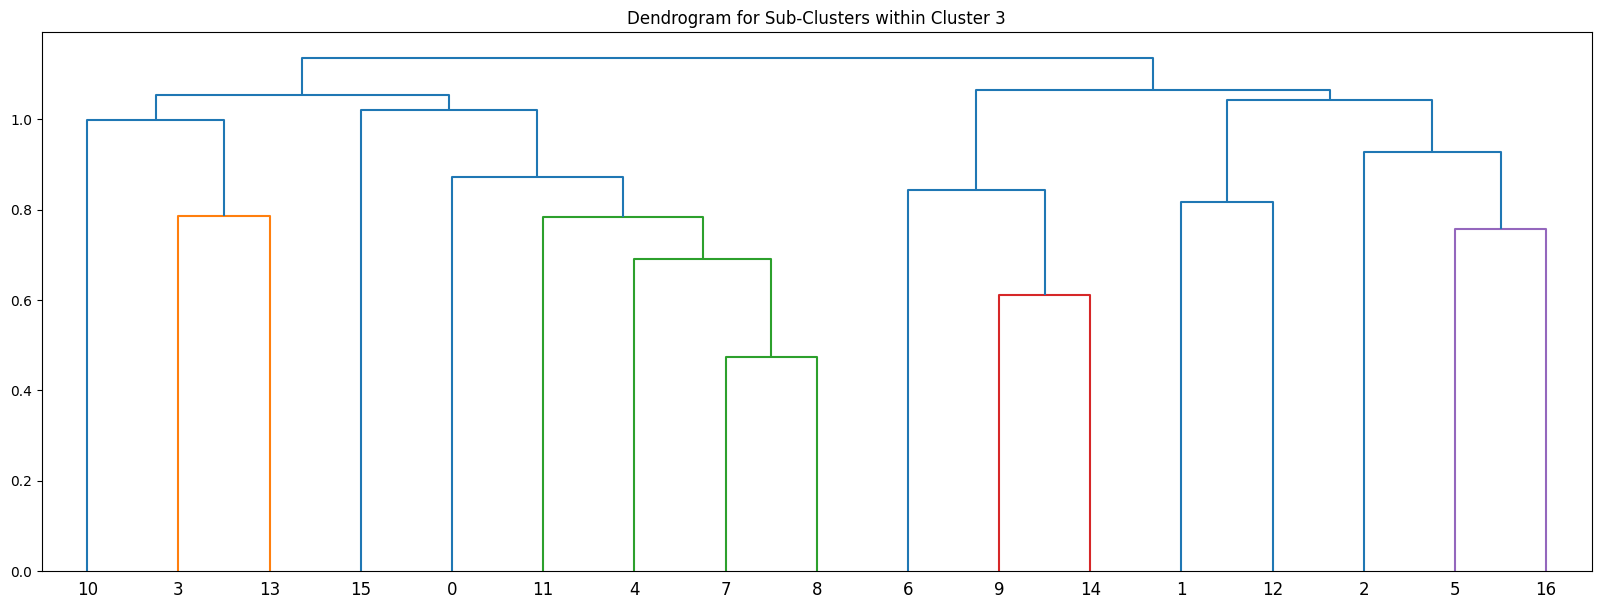

In [74]:
show_subcluster(df, target_cluster=3)

In [75]:
target_cluster = 3
i = 0
dic = {}
max_d_range = np.arange(0.8, 1.2,0.02).tolist()
for d in max_d_range:
        clusters_train = fcluster(compute_cluster(target_cluster), d, criterion='distance')
        
        # Get unique elements and their counts
        unique_elements, counts = np.unique(clusters_train, return_counts=True)

        # Combine unique elements and counts into a dictionary for better readability
        cluster_counts = dict(zip(unique_elements, counts))  
        
        # Extract the counts (number of articles in each cluster)
        article_counts = np.array(list(cluster_counts.values()))

        # Calculate mean, median, and standard deviation
        mean_articles = np.mean(article_counts)
        stddev_articles = np.std(article_counts)

        # Specify the percentiles you want to calculate
        percentiles = [10, 25, 33, 65, 50, 70, 75, 80,81,82,83,84,85, 86,87,88,89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
        percentile_values = np.percentile(article_counts, percentiles)

        # Initialize the dictionary for the cluster
        dic[d] = {}
        dic[d]['num_clusters'] = len(article_counts)

        # Add mean, median, and standard deviation
        dic[d]['mean'] = round(mean_articles, 2)
        dic[d]['std'] = round(stddev_articles, 2)

        # Add the percentiles
        for i, percentile in enumerate(percentiles):
            dic[d][f'{percentile}th'] = round(percentile_values[i], 2)
        i += 1

    # Convert the dictionary to a DataFrame
data = []

for d, stats in dic.items():
        for key, value in stats.items():
            if key in ['mean', 'std']:
                data.append({'max_d': d, 'statistic': key, 'value': value})
            elif key not in ['num_clusters']:
                percentile = int(key.replace('th', ''))
                data.append({'max_d': d, 'statistic': f'{percentile}', 'value': value})

# Create DataFrame with all values
distribution_df = pd.DataFrame(data)

# Pivot the DataFrame to have percentiles and other statistics as columns
pivot_df = distribution_df.pivot(index='max_d', columns='statistic', values='value')
pivot_df.reset_index(inplace=True)

# Rename the columns for better readability (optional)
pivot_df.columns.name = None
pivot_df.rename(columns={col: f'{col}' if isinstance(col, int) else col for col in pivot_df.columns}, inplace=True)    
print("Distribution for Body embeddings:")
print(tabulate(pivot_df, headers='keys', tablefmt='psql'))

Distribution for Body embeddings:
+----+---------+------+-------+-------+------+-------+------+-------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+-------+
|    |   max_d |   10 |    25 |    33 |   50 |    65 |   70 |    75 |   80 |    81 |    82 |    83 |    84 |    85 |    86 |    87 |    88 |    89 |   90 |    91 |    92 |    93 |    94 |    95 |    96 |    97 |    98 |    99 |   mean |   std |
|----+---------+------+-------+-------+------+-------+------+-------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+-------|
|  0 |    0.8  |  1   |  1    |  1    |  1   |  1.5  |  2   |  2    |  2   |  2    |  2    |  2    |  2    |  2    |  2    |  2    |  2    |  2    |  2   |  2.2  |  2.4  |  2.6  |  2.8  |  3    |  3.2  |  3.4  |  3.6  |  3.8  |   1

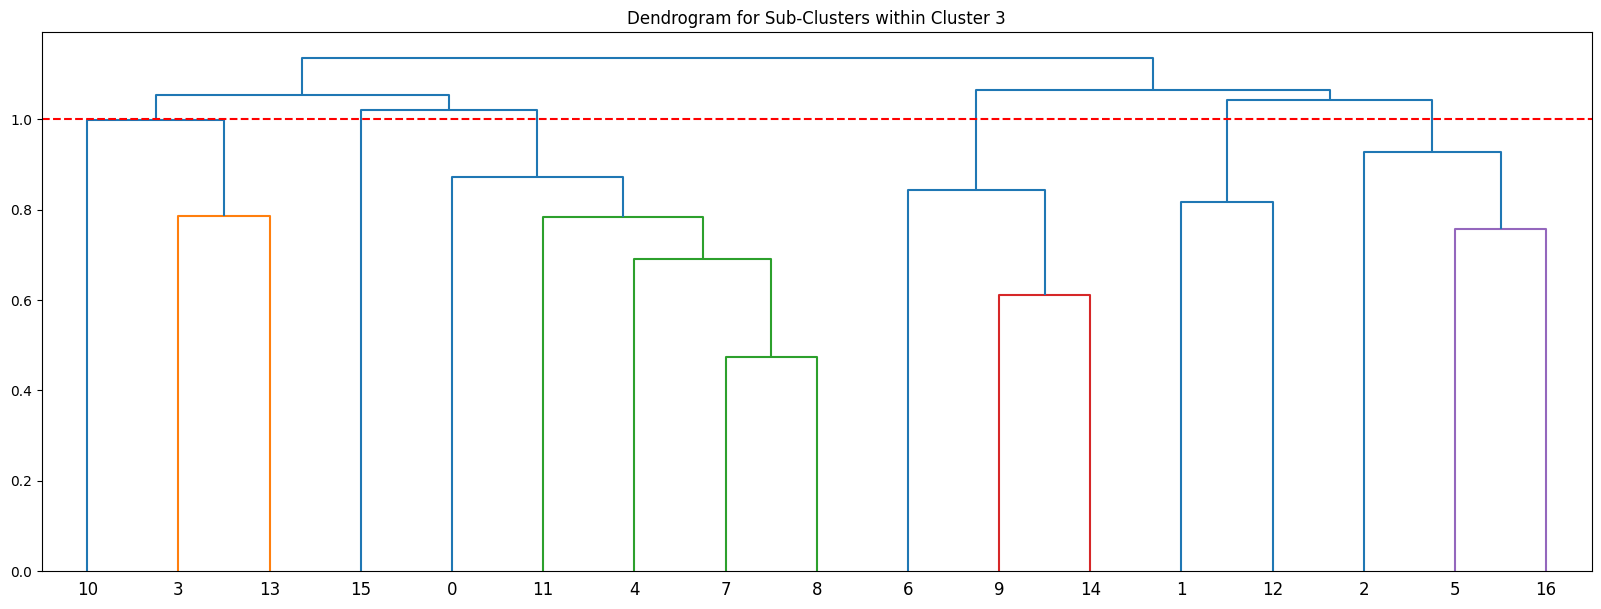

In [83]:
chosen_d = 1.0
# Plot the dendrogram for the sub-cluster
plt.figure(figsize=(20, 7))
plt.title(f"Dendrogram for Sub-Clusters within Cluster {target_cluster}")
dendrogram(compute_cluster(target_cluster))
plt.axhline(y=chosen_d, color='r', linestyle='--')
plt.show()

In [84]:
max_d = chosen_d
clusters_train = fcluster(Z_target, max_d, criterion='distance')
    
# Get unique elements and their counts
unique_elements, counts = np.unique(clusters_train, return_counts=True)

# Combine unique elements and counts into a dictionary for better readability
cluster_counts = dict(zip(unique_elements, counts))  
    
# Extract the counts (number of articles in each cluster)
article_counts = np.array(list(cluster_counts.values()))

labels = clusters_train.tolist()
target_data = df[df["Cluster_labels"] == target_cluster].reset_index()

target_data['Cluster_labels'] = labels

# WHat i want to find out is what the labels of each cluster are in each of these percentiles. 
def view_cluster(df, cluster_num):
    label = list(cluster_counts.keys())[cluster_num-1]
    print(f"Cluster {label}\n")
    print("-" * 80)
    s = ""
    count = 0
    for t in df[df['Cluster_labels'] == label]['Title'].values.tolist():
        s += f"- {t}\n" 
        print(f"- {t}\n")
        count += 1
    print(f"Number of articles: {count}")
    generated_label = groq_header(s)
    print(f"Generated label: {generated_label}\n")
    return generated_label

sub_cluster_labels = []
for i in range(len(set(labels))):
    sub_cluster_label = view_cluster(target_data, i)
    sub_cluster_labels.append(sub_cluster_label)